<__main__.Opt instance at 0x7f8a44440368>
Now entering into directory "../hpc/assets/c14m4d17" :::::
Loading files...
{'cohort': '14', 'mouse': '4', 'day': '17', 'day_type': 'allo'}
Detecting transients...
Now entering into directory "../hpc/assets/c14m4d16" :::::
Loading files...
{'cohort': '14', 'mouse': '4', 'day': '16', 'day_type': 'ego_to_allo'}
Detecting transients...
Now entering into directory "../hpc/assets/c14m4d15" :::::
Loading files...
{'cohort': '14', 'mouse': '4', 'day': '15', 'day_type': 'ego'}
Detecting transients...


[None, None, None]

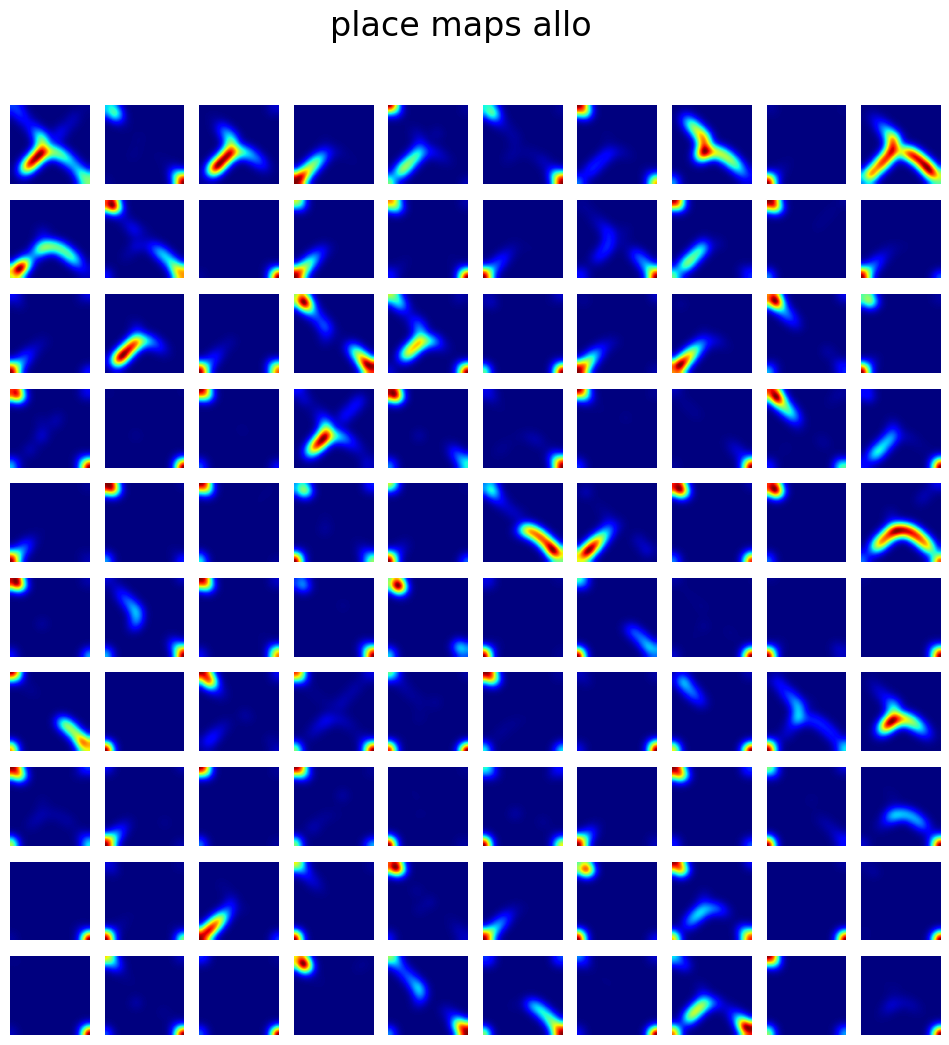

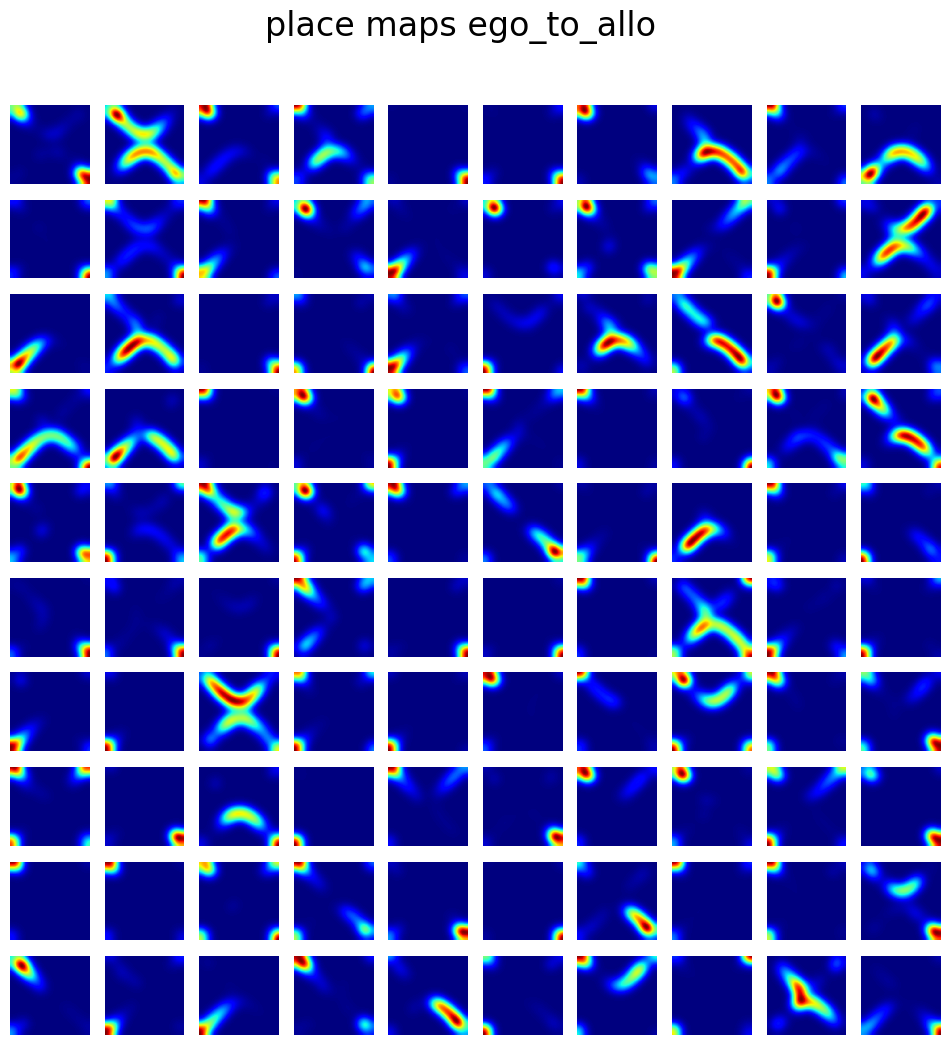

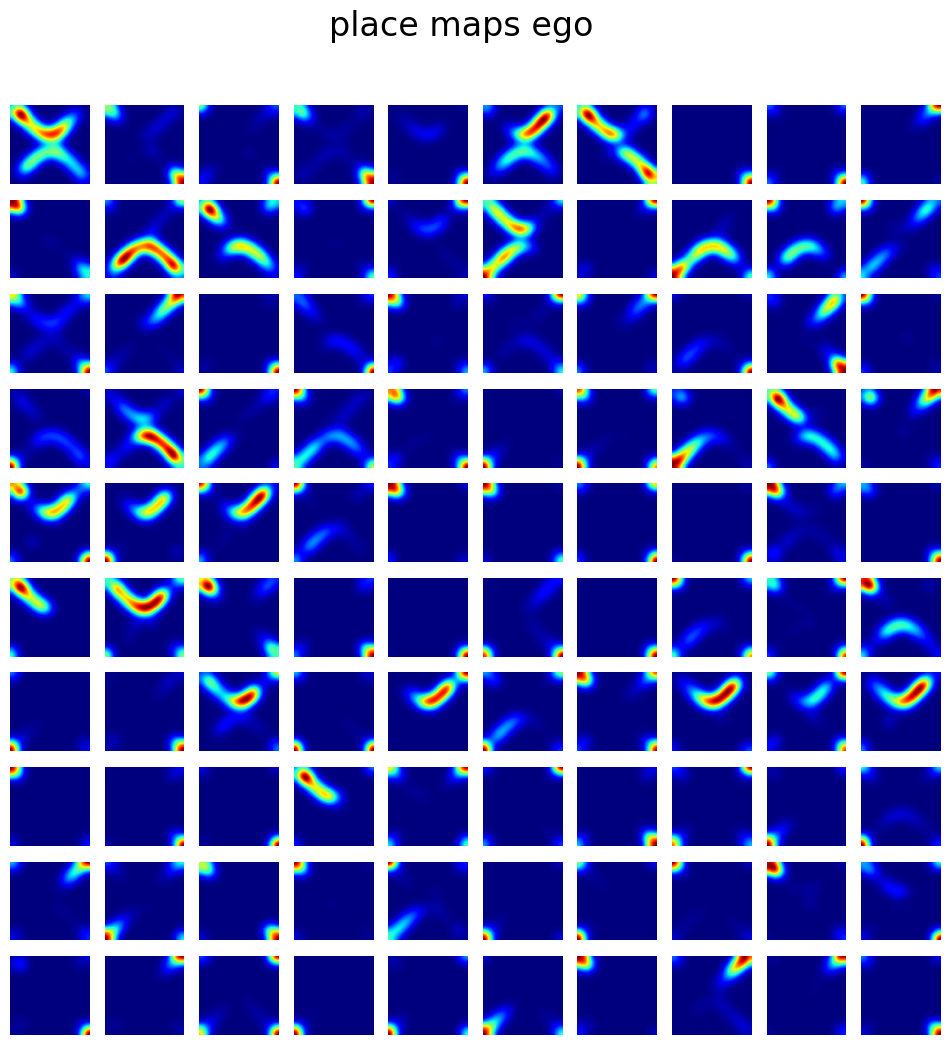

In [92]:
from day_loader import process_subdirs, l1_err
import place_decoder
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from joblib import Memory
from collections import namedtuple
#Opt = namedtuple('Opt', 'DIVS LOOKBACK FUTURE TRAIN_FRACTION N_SHUFS N_BATCH')

#opt = \
#Opt(
#DIVS=11,
#LOOKBACK=8,
#FUTURE=51,
#TRAIN_FRACTION=0.5,
#N_SHUFS=500,
#N_BATCH=20,
#)
class Opt:
    pass
opt = Opt()
opt.DIVS=11
opt.LOOKBACK=7
opt.FUTURE=51
opt.TRAIN_FRACTION=0.5
opt.N_SHUFS=500
opt.N_BATCH=20

memory = Memory(cachedir='/tmp/tmp_day_loader_joblib', verbose=0)

def transient_viewer(transients, xy, t_ranges, dirname, opt, label='unlabeled'):
    #plt.figure(figsize=(12,4))
    plt.figure()
    cell_ind = 13
    amount = 2000
    plt.plot(2*transients[cell_ind,:amount], 'g', label='detected transients')
    plt.hold(True)
    plt.plot(opt.original_traces[cell_ind,:amount], 'b', label='original trace')
    plt.plot((np.mean(opt.original_traces[cell_ind]) + 1.5*np.std(opt.original_traces[cell_ind]))*np.ones([amount]), 'r', label='1.5 SD')
    plt.legend()
    plt.title('transients for a cell in %s' % label)
    
def place_maps(transients, xy, t_ranges, dirname, opt, label='unlabeled'):
    cats = place_decoder.locs_to_cats(xy, divs=opt.DIVS)
    cell_inds = transients.sum(1).argsort()[::-1][:100]
    f, axs = plt.subplots(10,10, sharex='col', sharey='row')
    f.suptitle('place maps %s' % label, fontsize=24)
    f.set_size_inches(12,12)
    for ix, cell_ind in enumerate(cell_inds):
        mask = transients[cell_ind] == 1
        import scipy.ndimage as ndimage
        min_x, max_x = xy[:,0].min(), xy[:,0].max()
        min_y, max_y = xy[:,1].min(), xy[:,1].max()
        xy_ = np.int64(np.round(xy - xy.min(0)))
        image = np.zeros(xy_.max(0)[::-1]+1)
        np.add.at(image, (xy_[mask,1], xy_[mask,0]), 1)
        #8 px is ~1cm
        cm = 8
        image = ndimage.gaussian_filter(image, sigma=3.5*cm)
        #plt.figure()
        ax = axs[ix/10,ix%10]
        ax.matshow(image)
        ax.axes.get_yaxis().set_visible(False)
        ax.axes.get_xaxis().set_visible(False)
        ax.axis('off')
        #ax.margins(x=0,y=0)
        #plt.title('smooth place map for cell %d in %s (1-?)' % (cell_ind+1, label))


def simple_plotter(transients, xy, t_ranges, dirname, label='unlabeled'):
    print 'Running future prediction, for simple plots...'
    future = np.arange(FUTURE)
    for lb in xrange(8):
        plt.figure()
        frac = 1.0*lb/7
        self_errs = place_decoder.self_predictor(xy, DIVS, TRAIN_FRACTION, N_SHUFS, N_BATCH, lb, t_ranges, future)
        errs = place_decoder.predictor(transients, xy, DIVS, TRAIN_FRACTION, N_SHUFS, N_BATCH, lb, t_ranges, future)
        plt.plot(future, self_errs, '-o', color=(1,0,frac), label='prediction from position')
        plt.plot(future, errs, '-x', color=(0,1,frac), label='prediction from transients')
        plt.ylim([0,1])
        plt.xlabel('Frames ahead to predict')
        plt.ylabel('Prediction error')
        plt.title('Future prediction, decoding includes %d past frames, %s session' % (lb,label))
        plt.legend(loc='best')
        plt.savefig(label+'_fut_pred_hist_%d.png' % lb)

def errs_by_trial(inf_mats, act_mats, t_ranges, times):
    dists_tot = 0; count_tot = 0; onezeros_tot = 0
    l1s = []
    onezeros = []
    l1s_raw =[]
    onezeros_raw =[]
    untimes = {t:i for i,t in enumerate(times)}
    for s,e in t_ranges:
        dist = 0; count = 0; onezero = 0
        for t in xrange(s,e):
            if t in untimes:
                xi, yi = inf_mats[untimes[t]].nonzero()
                xa, ya = act_mats[untimes[t]].nonzero()
                xi, yi, xa, ya = map(lambda x: x[0], [xi, yi, xa, ya])
                myl1 = abs(xi-xa)+abs(yi-ya)
                myonezero = 0 if (xi==xa) and (yi==ya) else 1 
                dist += myl1
                onezero += myonezero
                l1s_raw.append(myl1)
                onezeros_raw.append(myonezero)
                count += 1
        dists_tot+=dist
        count_tot+=count
        onezeros_tot += onezero

        l1s.append(1.0*dist/count) if count != 0 else None
        onezeros.append(1.0*onezero/count) if count != 0 else None
    return 1.0*dists_tot/count_tot, 1.0*onezeros_tot/count_tot, l1s, onezeros, l1s_raw, onezeros_raw
def metron(transients, xy, t_ranges, dirname, opt, label='unlabeled'):
    err, errmat, inf_mats, act_mats, times, enc_data =\
        memory.cache(place_decoder.evaluate)(transients, xy, opt.DIVS, opt.TRAIN_FRACTION, opt.N_SHUFS, opt.N_BATCH, opt.LOOKBACK, t_ranges)
    #avg_dist_err = l1_err(inf_mats, act_mats, t_ranges, times)
    l1_avg, onezero_avg, l1s, onezeros, l1s_raw, onezeros_raw = errs_by_trial(inf_mats, act_mats, t_ranges, times)
    return label, (l1_avg, onezero_avg, l1s, onezeros, l1s_raw, onezeros_raw)

#process_subdirs('../assets/', simple_plotter)
#print opt
"""
res_hpc = process_subdirs('../hpc/assets/', metron, opt)
res_mpfc = process_subdirs('../mpfc', metron, opt)
"""
##opt.send_original_traces = True
##rocess_subdirs('../hpc/assets/', transient_viewer, opt)
#################################################################FOR DRAWING PLACE MAPS
#process_subdirs('../hpc/assets/', place_maps, opt)

In [107]:

def res_plotter(res, set_label):
    x = np.arange(len(res))
    y = []
    y_10 = []
    errs_10 =[]
    errs =[]
    pertrial_errs = []
    pertrial_errs_10 = []
    labs = []
    nums_by_lab = {}
    for label, (l1_avg, onezero_avg, l1s, onezeros, l1s_raw, onezeros_raw) in res:
        y.append(l1_avg)
        errs.append(np.std(l1s_raw))
        pertrial_errs.append(np.std(l1s))
        labs.append(label)
        y_10.append(onezero_avg)
        errs_10.append(np.std(onezeros_raw))
        pertrial_errs_10.append(np.std(onezeros))
        
        nums_by_lab[label] = (l1s, onezeros, l1s_raw, onezeros_raw)

    if 'ego' in nums_by_lab and 'allo' in nums_by_lab:
        from scipy.stats import ttest_ind
        pv = lambda a,b: ttest_ind(a,b, equal_var=False)[1]
        comp_list = ['per trial L1 errors', 'per trial 1-0 errors', 'L1 errors', '1-0 errors']
        for i, desc in enumerate(comp_list):
            print set_label + ': ' + desc + (': ttest pval: %f' % pv(nums_by_lab['ego'][i], nums_by_lab['allo'][i]))
            f = lambda x: [xi for xi in x if xi < 1]
            print set_label + ' (filter < 1): ' + desc + (': ttest pval: %f' % pv(f(nums_by_lab['ego'][i]), f(nums_by_lab['allo'][i])))
    plt.figure()
    plt.bar(x,y,ecolor='r', yerr=errs)
    plt.xticks(np.array(x)+0.4, labs)
    plt.title('%s: L1 avg. errs & total std' % set_label)

    plt.figure()
    plt.bar(x,y,ecolor='g', yerr=pertrial_errs)
    plt.xticks(np.array(x)+0.4, labs)
    plt.title('%s: L1 avg. errs & per trial std' % set_label)

    if 'ego' in nums_by_lab and 'allo' in nums_by_lab:
        plt.figure()
        plt.hist(nums_by_lab['ego'][0], color=(0,0,1,0.5), range=[0,10], bins=150, label='ego')
        plt.hold(True)
        plt.hist(nums_by_lab['allo'][0], color=(0,1,0,0.5), range=[0,10], bins=150, label='allo')
        plt.xlim([0,6])
        plt.legend(loc='best')
        plt.title('pertrial L1 errors')

    plt.figure()
    plt.bar(x,y_10,ecolor='r', yerr=errs_10)
    plt.xticks(np.array(x)+0.4, labs)
    plt.title('%s: 1-0 avg. errs & total std' % set_label)

    plt.figure()
    plt.bar(x,y_10,ecolor='g', yerr=pertrial_errs_10)
    plt.xticks(np.array(x)+0.4, labs)
    plt.title('%s: 1-0 avg. errs & per trial std' % set_label)
    
    if 'ego' in nums_by_lab and 'allo' in nums_by_lab:
        plt.figure()
        plt.hist(nums_by_lab['ego'][1], color=(0,0,1,0.5), range=[0.1,0.6], label='ego')
        plt.hold(True)
        plt.hist(nums_by_lab['allo'][1], color=(0,1,0,0.5), range=[0.1,0.6], label='allo')
        plt.xlim([0,1])
        plt.legend(loc='best')
        plt.title('pertrial 1-0 errors')

In [103]:
import os
from glob import glob
import day_loader
import transient_detection as tdet

topdir = '../hpc/assets'
match_file = open(os.path.join(topdir, 'match-fix.txt'))
table = np.array([map(int,line.split(' ')) for line in match_file.read().split('\n') if line != ''])

#m_ind_15 = table[:,0]
#m_ind_16 = table[:,1]
#m_ind_17 = table[:,2]
match_tab = dict(c14m4d15=table[:,0], c14m4d16=table[:,1], c14m4d17=table[:,2])


def metron2(transients, xy, t_ranges, dirname, opt, specific_inds, label='unlabeled'):
    transients = transients[specific_inds, :]
    err, errmat, inf_mats, act_mats, times, enc_data =\
        memory.cache(place_decoder.evaluate)(transients, xy, opt.DIVS, opt.TRAIN_FRACTION, opt.N_SHUFS, opt.N_BATCH, opt.LOOKBACK, t_ranges)
    #avg_dist_err = l1_err(inf_mats, act_mats, t_ranges, times)
    l1_avg, onezero_avg, l1s, onezeros, l1s_raw, onezeros_raw = errs_by_trial(inf_mats, act_mats, t_ranges, times)
    return label, (l1_avg, onezero_avg, l1s, onezeros, l1s_raw, onezeros_raw)

opt = Opt()
opt.DIVS=11
opt.LOOKBACK=7
opt.FUTURE=51
opt.TRAIN_FRACTION=0.5
opt.N_SHUFS=500
opt.N_BATCH=20

res_hpc = []
for d in glob(os.path.join(topdir,'*')):
    if os.path.isdir(d):
        code = os.path.basename(d)
        m_inds = match_tab[code]
        py_inds = m_inds-1  ##index correction
        traces, xy, t_ranges, meta = day_loader.load_from_dir(d)
        transients = tdet.detect(traces)
        res_hpc.append(metron2(transients, xy, t_ranges, d, opt, py_inds, label=meta['day_type']))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   37.8s finished


0 out of 214 had insignificant mutual information


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   45.0s finished


0 out of 214 had insignificant mutual information


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   41.5s finished


0 out of 214 had insignificant mutual information


HPC: per trial L1 errors: ttest pval: 0.219094
HPC (filter < 1): per trial L1 errors: ttest pval: 0.014359
HPC: per trial 1-0 errors: ttest pval: 0.016314
HPC (filter < 1): per trial 1-0 errors: ttest pval: 0.016314
HPC: L1 errors: ttest pval: 0.000000
HPC (filter < 1): L1 errors: ttest pval: nan
HPC: 1-0 errors: ttest pval: 0.006179
HPC (filter < 1): 1-0 errors: ttest pval: nan


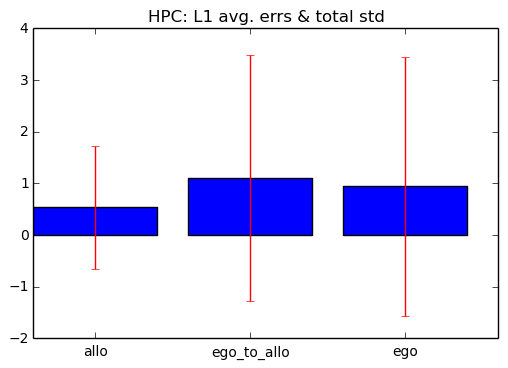

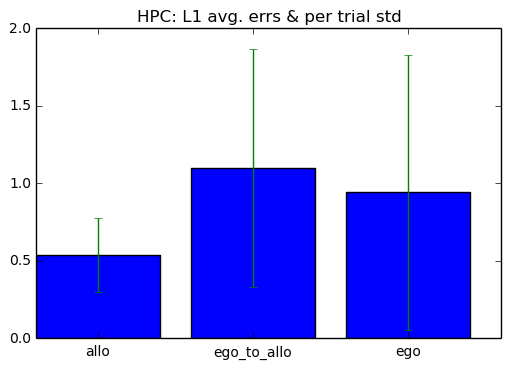

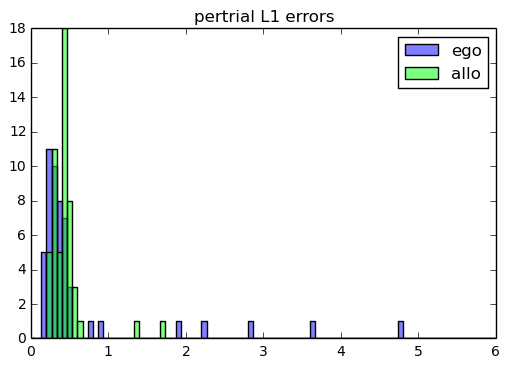

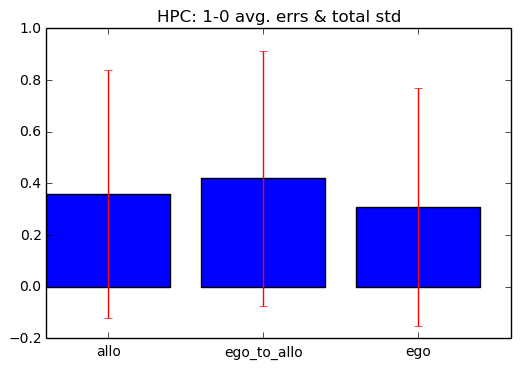

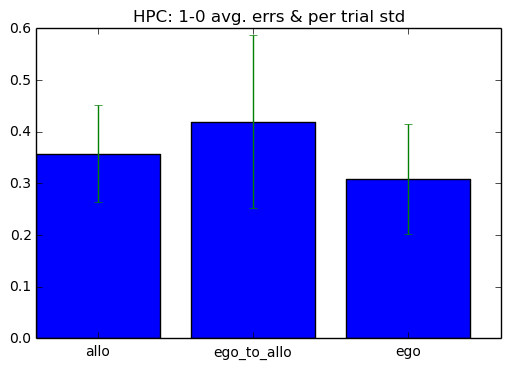

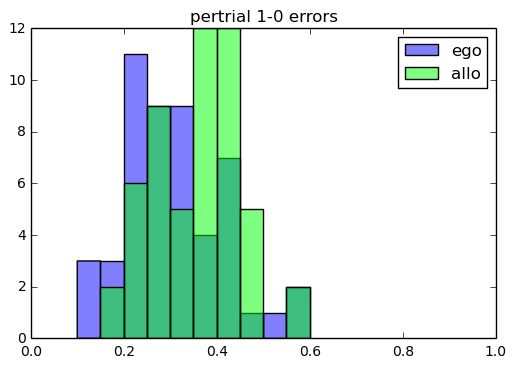

In [108]:
res_plotter(res_hpc, 'HPC')
#res_plotter(res_mpfc, 'mPFC')

In [3]:
%pwd

u'/home/omer/brain/hpc/src'

In [13]:
from glob import glob
import day_loader
import transient_detection as tdet
import place_decoder
import numpy as np
import matplotlib.pyplot as plt
import yaml
%matplotlib inline

topdir = '../assets'
#DIVS = 13
TRAIN_FRACTION = 0.5

err_dict, errmat_dict, errs_per_range_dict = {}, {}, {}

for dirname in glob(topdir + '/*'):
    ##print 'processing dir %s' % dirname
    traces, xy, t_ranges = day_loader.load_from_dir(dirname)
    meta = yaml.load(open(dirname + '/meta.yaml'))
    ##print meta
    ##print 'detecting transients'
    transients = tdet.detect(traces)
    for DIVS in range(1,101):
        err, errmat, inference_mats, actual_mats, times =\
            place_decoder.evaluate(transients, xy, DIVS, TRAIN_FRACTION, t_ranges)
        errs_per_range = []
        for s,e in t_ranges:
            if s in times:
                s_ind = np.argmax(s == times)
                e_ind = np.argmax(e == times)
                errs_per_range.append(np.mean(np.any(inference_mats[s_ind:e_ind] != actual_mats[s_ind:e_ind], (1,2))))
        ##print 'the total error rate was %f%%' % (100*err)
        ##print 'the error rate by location was:'
        errmat[np.isnan(errmat)] = -0.01
        ##print np.int64(np.round(errmat*100))
        ##print 'the error rates per trial tested are:'
        ##print errs_per_range
        err_dict[dirname, DIVS] = err
        errmat_dict[dirname, DIVS] = errmat
        errs_per_range_dict[dirname, DIVS] = errs_per_range
        print 'done', dirname, DIVS
        ##plt.figure()
        ##plt.hist(errs_per_range)
        ##plt.title('Error rate on tested trials for %s type day' % meta['day_type'])
        ##plt.xlim([0.,1.])
        ##plt.ylim([0.,18.])


loaded traces (663, 13477)
confirmed_cell_traces (329, 13477)
xy positions per frame (13477, 2)
props loaded, len=100
done ../assets/c14m4d17 1
done ../assets/c14m4d17 2
done ../assets/c14m4d17 3
done ../assets/c14m4d17 4
done ../assets/c14m4d17 5
done ../assets/c14m4d17 6
done ../assets/c14m4d17 7
done ../assets/c14m4d17 8
done ../assets/c14m4d17 9
done ../assets/c14m4d17 10
done ../assets/c14m4d17 11
done ../assets/c14m4d17 12
done ../assets/c14m4d17 13
done ../assets/c14m4d17 14
done ../assets/c14m4d17 15
done ../assets/c14m4d17 16
done ../assets/c14m4d17 17
done ../assets/c14m4d17 18
done ../assets/c14m4d17 19
done ../assets/c14m4d17 20
done ../assets/c14m4d17 21
done ../assets/c14m4d17 22
done ../assets/c14m4d17 23
done ../assets/c14m4d17 24
done ../assets/c14m4d17 25
done ../assets/c14m4d17 26
done ../assets/c14m4d17 27
done ../assets/c14m4d17 28
done ../assets/c14m4d17 29
done ../assets/c14m4d17 30
done ../assets/c14m4d17 31
done ../assets/c14m4d17 32
done ../assets/c14m4d17 33


In [11]:
import pickle
pickle.dump((err_dict, errmat_dict, errs_per_range_dict), open('param_sweep_data.p', 'wb'))

NameError: name 'err_dict' is not defined

In [14]:
import pickle
err_dict, errmat_dict, errs_per_range_dict = pickle.load(open('param_sweep_data.p'))

median err rate for ego is 28.571429%
median err rate for e2a is 38.492063%
median errrate for allo is 38.095238%


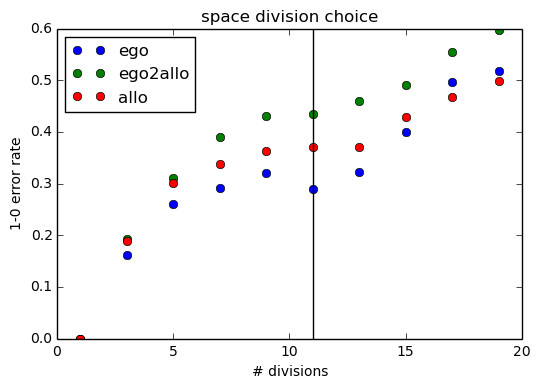

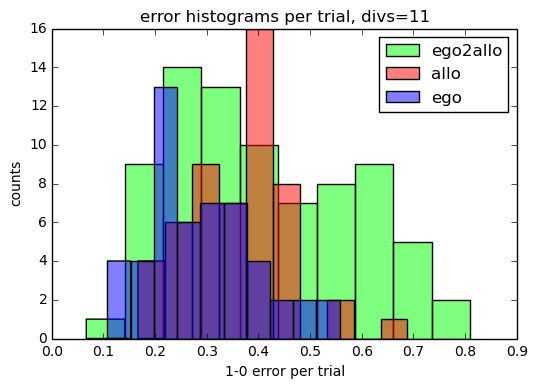

In [17]:
ego_errs = [err_dict['../assets/c14m4d15', i] for i in range(1,101)]
e2a_errs = [err_dict['../assets/c14m4d16', i] for i in range(1,101)]
allo_errs= [err_dict['../assets/c14m4d17', i] for i in range(1,101)]

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(); plt.plot(range(1,101)[:20:2], ego_errs[:20:2], 'o', label='ego')
plt.hold(True); plt.plot(range(1,101)[:20:2], e2a_errs[:20:2], 'og', label='ego2allo')
plt.hold(True); plt.plot(range(1,101)[:20:2], allo_errs[:20:2], 'or', label='allo')
plt.legend(loc='best')
plt.title("space division choice")
plt.xlabel('# divisions')
plt.ylabel('1-0 error rate')
plt.axvline(11,color='k')

ideal_divs = 11
ego_rs = errs_per_range_dict['../assets/c14m4d15', ideal_divs]
e2a_rs = errs_per_range_dict['../assets/c14m4d16', ideal_divs]
allo_rs= errs_per_range_dict['../assets/c14m4d17', ideal_divs]
plt.figure()
plt.hold(True); plt.hist(e2a_rs, color=[0,1,0,.5], label='ego2allo')
plt.hist(allo_rs, color=[1,0,0,.5], label='allo'); plt.hist(ego_rs, color=[0,0,1,.5], label='ego')
plt.title('error histograms per trial, divs=11')
plt.xlabel('1-0 error per trial')
plt.ylabel('counts')
plt.legend(loc='best')
print 'median err rate for ego is %f%%' % (np.median(ego_rs)*100)
print 'median err rate for e2a is %f%%' % (np.median(e2a_rs)*100)
print 'median errrate for allo is %f%%' % (np.median(allo_rs)*100)

Shift cats backwards in time to find out predictive power and plot err vs backward time shift

In [11]:
from joblib import Memory
from tempfile import mkdtemp

cachedir = mkdtemp()
mem = Memory(cachedir=cachedir, verbose=0)

In [1]:
#%%prun
from sklearn.metrics import mutual_info_score
from glob import glob
import day_loader
import transient_detection as tdet
import place_decoder
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import yaml


topdir = '../assets'
DIVS = 11
TRAIN_FRACTION = 0.5
NSHUFS_BATCH = 500
N_BATCH = 20

def muti1(c1,c2, n1, n2):
    count = np.zeros([n1,n2])
    np.add.at(count, (c1,c2), 1)
    return mutual_info_score(None,None,contingency=count)
def muti2(clean_cats, ncats, tr, nc, nt):
    nct = np.bincount(clean_cats[tr==1], minlength=ncats)
    N = len(tr)
    mask_t = (nct != 0)
    mask_f = (nct != nc)
    nct_t = nct[mask_t]
    nc_t = nc[mask_t]
    nct_f = nct[mask_f]
    nc_f = nc[mask_f]
    
    ncf_f = nc_f - nct_f
    nf = N - nt
    true_comp  = np.sum(nct_t*np.log(1.0*N*nct_t/nc_t/nt))
    false_comp = np.sum(ncf_f*np.log(1.0*N*ncf_f/nc_f/nf))
    return 1./N * (true_comp + false_comp)
def muti3_old(css, Nc, bs, nc):
    ncs_1 = np.apply_along_axis(lambda x: np.bincount(x, minlength=Nc), 1, css[:, bs==1])
    ncs_0 = nc - ncs_1
    N = len(bs)
    nb1 = bs.sum()
    nb0 = N - nb1
    return 1./N * (np.nansum(ncs_1 * np.log(1.*N*ncs_1/nc/nb1),1) +\
                   np.nansum(ncs_0 * np.log(1.*N*ncs_0/nc/nb0),1))
def muti3(css, Nc, bs, nc):
    ncs_1 = np.apply_along_axis(lambda x: np.bincount(x, minlength=Nc), 1, css[:, bs==1])
    ncs_0 = nc - ncs_1
    N = len(bs)
    nb1 = bs.sum()
    nb0 = N - nb1
    
    return (1./N * (ma.sum(ncs_1 * ma.log(1.*N*ncs_1/nc/nb1),1) +\
                   ma.sum(ncs_0 * ma.log(1.*N*ncs_0/nc/nb0),1))).data

def mega_muti(css, Nc, bss, nc):
    M_c, N_c = css.shape
    M_b, N_b = bss.shape
    assert N_c == N_b
    N = N_c
    assert len(nc) == Nc
    ncss_1 = np.empty([M_b, M_c, Nc])
    for i, bs in enumerate(bss):
        for j, cs in enumerate(css):
            ncss_1[i,j,:] = np.bincount(cs[bs==1], minlength=Nc)
    ncss_0 = nc - ncss_1
    nb1s = bss.sum(1)[:,None,None]
    nb0s = N - nb1s
    return 1./N * (np.nansum(ncss_1 * np.log(1.*N*ncss_1/nc/nb1s),2) +\
                   np.nansum(ncss_0 * np.log(1.*N*ncss_0/nc/nb0s),2))


cats = np.array([0,1,2,3,1,1,2])
tr = np.array([0,1,0,1,1,1,0])
print muti1(cats, tr, 4, 2)
print muti3(cats[None,:], 4, tr, np.bincount(cats, minlength=4))

import pdb
qs_dict = {}
for dirname in glob(topdir + '/*')[2:]: ##########################TODO !!!!!!!   make mutual information part of the pipeline
    print 'processing dir %s' % dirname
    traces, xy, t_ranges, meta = day_loader.load_from_dir(dirname)
    num_cells, num_frames = traces.shape
    meta = yaml.load(open(dirname + '/meta.yaml'))
    print meta
    print 'detecting transients'
    #transients = mem.cache(tdet.detect)(traces)
    transients = tdet.detect(traces)
    #pdb.set_trace()
    cats = place_decoder.locs_to_cats(xy, DIVS)
    
    
    uniq_cats, clean_cats = np.unique(cats, return_inverse=True)
    nc = np.bincount(clean_cats, minlength=len(uniq_cats))
    print 'clean_cats shape: ', clean_cats.shape
    print 'nc shape: ', nc.shape
    #mutis = np.apply_along_axis(lambda c: muti3(clean_cats[None,:], len(uniq_cats), c, nc)[0], 1, transients[:num_cells])
    mutis = mega_muti(clean_cats[None,:], len(uniq_cats), transients[:num_cells], nc)[:,0]
    old_mutis = np.apply_along_axis(lambda c: muti1(clean_cats, c, len(uniq_cats), 2), 1, transients[:num_cells])
    assert np.all(np.abs(mutis - old_mutis) < 0.0001)
    batches = []
    print 'batch',
    for k in xrange(N_BATCH):
        permcats = np.vstack([np.random.permutation(clean_cats) for _ in xrange(NSHUFS_BATCH)])
        batches.append(np.vstack([muti3(permcats, len(uniq_cats), transients[i], nc) for i in xrange(num_cells)]))
        #batches.append(mega_muti(permcats, len(uniq_cats), transients[:num_cells], nc))
        print '%d/%d' % (k+1, N_BATCH),
    print
    shuf_mutis = np.hstack(batches)
    qs = []
    for i in xrange(num_cells):
        muti = mutis[i]
        shufs = shuf_mutis[i]
        p = (shufs >= muti).sum()*1.0 / len(shufs)
        q = p * num_cells
        if p != 0:
            print "cell %d has p = %f, q = %f" % (i,p,q)
        if q >= 0.05:
            print '\tcell %d is not a place field (q>=0.05)' % i
        qs.append(q)
    qs_dict[dirname] = qs

0.6829081047
[ 0.6829081]
processing dir ../assets/c14m4d15
loaded traces (781, 15003)
confirmed_cell_traces (364, 15003)
xy positions per frame (15003, 2)
props loaded, len=110
{'cohort': 14, 'mouse': 4, 'day': 15, 'day_type': 'ego'}
detecting transients
> /home/omer/brain/hpc/src/transient_detection.py(20)detect_maxima()
-> return valid_transient_peak
(Pdb) traces.sum()
1031691.8202367028
(Pdb) threshold.sum()
737.80508515142174
(Pdb) passing_threshold.sum()
186509
(Pdb) repeated_passing.sum()
107024
(Pdb) sig.convolve([0,0,0,1,1,1,0,0,0], np.ones([1,4]), 'same')
*** ValueError: in1 and in2 should have the same dimensionality
(Pdb) sig.convolve([[0,0,0,1,1,1,0,0,0]], np.ones([1,4]), 'same')
array([[ 0.,  0.,  1.,  2.,  3.,  3.,  2.,  1.,  0.]])
(Pdb) sig.convolve([[0,0,0,1,1,1,1,0,0,0]], np.ones([1,4]), 'same') >= 4
array([[False, False, False, False, False,  True, False, False, False,
        False]], dtype=bool)
(Pdb) sig.convolve([[0,0,0,1,1,1,1,0,0,0],[0,0,0,1,1,1,1,0,0,0]], np.o

BdbQuit: 

In [33]:
import h5py
import numpy as np

matfile = h5py.File('../hpc/assets/c14m4d15/cm01/rec_160410-081144.mat','r')
traces = np.array(matfile.get('traces'))
print 'loaded traces', traces.shape

real_cells = np.array(
    ['not' not in line 
     for line in open('../hpc/assets/c14m4d15/cm01/class_160419-112532.txt').read().split('\n')
     if 'cell' in line])
real_traces = traces[real_cells,:]
print 'confirmed cell traces', real_traces.shape

xy_pos = np.array(
    [map(float,line.split(' ')) 
     for line in open('../hpc/assets/c14m4d15/_data/c14m4d15_ti2.xy').read().split('\n') 
     if ' ' in line])
print 'xy positions per frame', xy_pos.shape

loaded traces (781, 15003)
confirmed cell traces (364, 15003)
xy positions per frame (15003, 2)


In [18]:
import day_loader
reload(day_loader)

tr, xy, pr = day_loader.load_from_dir('..')

IOError: [Errno 2] No such file or directory: '../meta.yaml'

In [3]:
#no_probes = pr[(pr.initial=='east') | (pr.initial=='west')]
#zip(no_probes.open, no_probes.close)

In [9]:
%%prun
import decoder
reload(decoder)
import visual_analyzer
import transient_detection as tdet

#cell_ids, time_inds, mags = tdet.detect(real_traces)
transients = tdet.detect(real_traces)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
%matplotlib

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
t = np.arange(0.0, 1.0, 0.001)
a0 = 5
f0 = 3
s = a0*np.sin(2*np.pi*f0*t)
l, = plt.plot(t, s, lw=2, color='red')
plt.axis([0, 1, -10, 10])

axcolor = 'lightgoldenrodyellow'
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], axisbg=axcolor)
axamp = plt.axes([0.25, 0.15, 0.65, 0.03], axisbg=axcolor)

sfreq = Slider(axfreq, 'Freq', 0.1, 30.0, valinit=f0)
samp = Slider(axamp, 'Amp', 0.1, 10.0, valinit=a0)


def update(val):
    amp = samp.val
    freq = sfreq.val
    l.set_ydata(amp*np.sin(2*np.pi*freq*t))
    fig.canvas.draw_idle()
sfreq.on_changed(update)
samp.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    sfreq.reset()
    samp.reset()
button.on_clicked(reset)

rax = plt.axes([0.025, 0.5, 0.15, 0.15], axisbg=axcolor)
radio = RadioButtons(rax, ('red', 'blue', 'green'), active=0)


def colorfunc(label):
    l.set_color(label)
    fig.canvas.draw_idle()
radio.on_clicked(colorfunc)

plt.show()

Using matplotlib backend: TkAgg


In [5]:
total_length = len(xy_pos)
train_fraction = 0.5
train_time = int(train_fraction * total_length)
test_time = total_length - train_time
divs = 13

rec_gen_maker = lambda divs=divs, train_fraction=train_fraction, ev=False:\
    decoder.transient_patterns_inferences(transients, xy_pos,\
        divs=divs, train_fraction=train_fraction, eval_mode=ev)

In [8]:
%%timeit
import place_decoder as pld

err, err_by_loc, _, _, _ = pld.evaluate(transients, xy_pos, divs=13, train_frac=0.5)
print 'avg err rate is %f%%' % (100*err)

avg err rate is 29.352173%
avg err rate is 29.352173%
avg err rate is 29.352173%
avg err rate is 29.352173%
1 loop, best of 3: 2.37 s per loop


In [ ]:
#%%prun
cats = decoder.locations_to_categories(xy_pos, divs=divs)
n_cats = divs**2
pats = transients.T == 1
train_frac = 0.5

test_time = int(train_frac * len(cats))

train_cats, test_cats = cats[:test_time], cats[test_time:]
train_pats, test_pats = pats[:test_time], pats[test_time:]

cat_labels = np.array(sorted(list(set(train_cats))))

cat_freqs  = np.array([np.sum(           train_cats==c ,0) for c in cl])
ev_x_cat   = np.array([np.sum(train_pats[train_cats==c],0) for c in cl]).T

lc   = np.log((cat_freqs            + 1.0)/(test_time + cat_labels.size))
legc = np.log((            ev_x_cat + 1.0)/(cat_freqs +               2))
lngc = np.log((cat_freqs - ev_x_cat + 1.0)/(cat_freqs +               2))

logprobs = np.apply_along_axis(lambda p: np.sum(legc[ p],0),1,test_pats) +\
           np.apply_along_axis(lambda p: np.sum(lngc[~p],0),1,test_pats) + lc

inferences = cat_labels[np.argmax(logprobs, 1)]

err = np.sum(inferences != test_cats)*1.0 / len(test_cats)
print "avg err rate is %f%%" % (100*err)

#np.apply_along_axis(lambda c: np.eye(n_cats)[c],0,test_cats)
raw_actuals = np.apply_along_axis(lambda c:np.eye(n_cats)[:,c[0]], 1, test_cats[:,np.newaxis])
err_by_loc = np.sum(1.0 * raw_actuals * (inferences != test_cats)[:,np.newaxis],0) / np.sum(raw_actuals,0)
print err_by_loc.reshape([divs,divs])

In [ ]:
%%prun
reload(decoder)
err, err_by_loc = rec_gen_maker(ev=True)
print 'avg err rate is %f%%' % (100*err)
errmat = err_by_loc.reshape((divs,divs))
print errmat

In [ ]:
import matplotlib.pyplot as plt

eee = np.copy(errmat)
eee[np.isnan(eee)] = -0.01
print np.int64(np.round(eee*100))

plt.matshow(1-errmat, vmin=0, vmax=1, cmap=plt.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [ ]:
reload(visual_analyzer)
visual_analyzer.display(rec_gen_maker(), test_time, divs)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from decoder import *
loc_cats = locations_to_categories(xy_pos[:,0], xy_pos[:,1], divs=divs)
k_cat = loc_cats[:test_time]
k_cell_ids, k_time_inds = zip(*[(e,t) for (e,t) in zip(cell_ids, time_inds) if t < test_time])
pri, evi, deco = decoding_function(k_cat, divs*divs, k_cell_ids, k_time_inds, True)
prior = np.exp(pri)
prior /= np.sum(prior)
err = 0
baseline_err = 0
count = 0
for t in xrange(test_time, test_time+1000):
    pattern = np.zeros((np.max(cell_ids)+1,), dtype=np.int)
    pattern[cell_ids[time_inds==t]] = 1
    inferred = deco(pattern)
    actual = np.eye(divs*divs)[loc_cats[t]]
    
    err = st.entropy(actual, inferred)
    baseline_err = st.entropy(actual, prior)
    #print 'for t=%d, error is %f, baseline is %f' % (t, err, baseline_err)
    print '%d:%f' % (t,err),
    count += 1
    if err > 1000:
        plt.matshow(np.vstack((actual, inferred, prior)))
        plt.title(str(t))
#err /= 1.0*count
#baseline_err /= 1.0*count
#print err, baseline_err

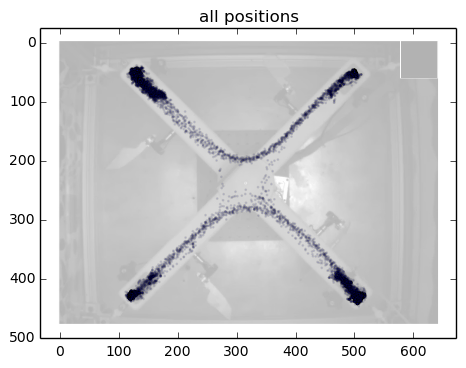

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

backg = plt.imread('../hpc/maze.png')
backg = 1-(1-backg)*0.3  #0.7 + 0.3*backg, or brighten the image by rescaling to 0.7-1 instead of 0-1
fig, ax = plt.subplots()
ax.imshow(backg)
ax.scatter(xy_pos[:,0], xy_pos[:,1], alpha=0.1, s=1)
plt.title('all positions')

In [35]:
def rescale(arr, val=1, nonmin=False):
    minv, maxv = np.min(arr), np.max(arr)
    if nonmin:
        minv = 0
    return (arr - minv)/(maxv - minv) * val


def map_index(ind, ax, z=3, color='b'):
    a_trace = np.copy(real_traces[ind,:])
    mean, std = np.mean(a_trace), np.std(a_trace)

    #plt.figure()
    my_pos = xy_pos[a_trace > mean + z*std,:]
    my_trace = a_trace[a_trace > mean + z*std]
    ax.scatter(my_pos[:,0], my_pos[:,1], alpha=0.1, s=rescale(my_trace, 20), c=color, edgecolors='none')
    #plt.title('draw spike places for trace %d' % ind)
    
def map_trace(trace, pos, color='b', titl='no title'):
    plt.figure()
    axes = plt.gca()
    axes.set_xlim([0,600])
    axes.set_ylim([0,500])
    plt.scatter(pos[:,0], pos[:,1], alpha=0.1, s=rescale(trace, 20), c=color, edgecolors='none')
    plt.title(titl)
    
def map_traces(traces, poss, colors, titl='no title'):
    fig, ax = plt.subplots()
    ax.imshow(backg)
    #axes = plt.gca()
    #axes.set_xlim([0,600])
    #axes.set_ylim([0,500])
    for trace, pos, color in zip(traces, poss, colors):
        ax.scatter(pos[:,0], pos[:,1], alpha=0.2, s=rescale(trace, 20), c=color, edgecolors='none')
    
    plt.title(titl)

def map_transients(trans_dict, pos, maxind=1e6, colorfunc=lambda x: 'black', title='no title'):
    fig, ax = plt.subplots()
    ax.imshow(backg)
    for k,(ts,mags) in trans_dict.iteritems():
        if k < maxind:
            ax.scatter(pos[ts,0], pos[ts,1], alpha=0.5, s=rescale(mags,20,nonmin=True), c=colorfunc(k), edgecolors='none')
    plt.title(title)

In [50]:
#fun with peak detection
import scipy.signal as sig

def viz(traces, upto=5000, title='no title'):
    plt.plot(traces[:upto])
    plt.title(title)
def subtract_median_window(traces, window_size=101):
    return traces - sig.medfilt(traces, [1,window_size])
def sliding_average(traces, window_size=3):
    return sig.convolve(traces, np.ones((1,window_size), dtype=int), 'same')/(1.*window_size)
def detect_maxima(traces, z=2, width=5, sep=3):
    threshold = z*np.reshape(np.std(traces, axis=-1), (-1,1))
    passing_threshold = np.int64(traces >= threshold)
    repeated_passing = sig.convolve(passing_threshold, np.ones((1,width)), 'same') >= width
    local_maximum = np.pad(np.diff(np.int64(np.diff(traces) > 0)) < 0, ((0,0),(1,1)), 'constant', constant_values=(0,0))
    well_sep_max = local_maximum
    for i in range(sep+1):
        well_sep_max &= ~np.roll(local_maximum,i+1)
    valid_transient_peak = repeated_passing & well_sep_max
    return valid_transient_peak
def process_transient_dots(valid_peaks, traces, offset_delay=3):
    rows, cols = valid_peaks.nonzero()
    peak_vals = traces[rows, cols]
    num_peaks = len(cols)
    transient_occurance_cols = []
    for ix in xrange(num_peaks):
        i, j = rows[ix], cols[ix]
        dropping = True
        old_val = traces[i,j]
        while dropping and j>0:
            j-=1
            new_val = traces[i,j]
            if new_val > old_val:
                dropping = False
            old_val = new_val
        # transient occurance is midpoint of peak & previous trough, pushed back due to GCaMP delay
        transient_occurance_cols.append((j + cols[ix])/2 - offset_delay) 
    return rows, np.array(transient_occurance_cols), peak_vals #rows, cols, and values at peaks (not at transient start)
def expand_transients(valid_peaks, traces, offset_delay=3):
    rows, cols = valid_peaks.nonzero()
    num_peaks = len(cols)
    transient_canvas = np.zeros_like(valid_peaks, dtype=np.int)
    for ix in xrange(num_peaks):
        i, j = rows[ix], cols[ix]
        dropping = True
        old_val = traces[i,j]
        while dropping and j > 0:
            j-=1
            new_val = traces[i,j]
            if new_val > old_val:
                dropping = False
            old_val = new_val
        start_of_transient = j - offset_delay
        end_of_transient = cols[ix] - offset_delay
        transient_canvas[i,start_of_transient:end_of_transient] = 1
    return transient_canvas


In [44]:
inp = np.array([[0,0,0,0,1,2,3,3,2,1,0,0,0,4,5,6,5,0,0,0,9,8,0,0,9,0],[0,0,0,0,1,2,6,6,2,1,0,0,0,4,5,6,5,0,0,0,9,8,0,0,90,0]])
print 'in', inp.shape
outp = detect_maxima(inp)
outp

bb=[False, False, True, True, True, True, True, False, False, False, True, False, False]
print 'binary conv', sig.convolve(bb, [1]*5, 'same') >= 5

threshold = np.reshape(np.max(inp, axis=-1),(-1,1))
print 'th', threshold
passing_threshold = inp >= threshold
repeated_passing = sig.convolve(passing_threshold, np.ones((1,5)), 'same') >= 5

local_maximum = np.pad(np.diff(np.int64(np.diff(inp) > 0)) < 0, ((0,0),(1,1)), 'constant', constant_values=(0,0))
#passing_threshold & local_maximum
#barbaric = local_maximum & (~np.roll(local_maximum,1)) & (~np.roll(local_maximum,2)) & (~np.roll(local_maximum,3)) & (~np.roll(local_maximum,4))
buf = local_maximum
for i in range(4):
    buf &= ~np.roll(local_maximum,i+1)
buf

in (2, 26)
binary conv [False False False False  True False False False False False False False
 False]
th [[ 9]
 [90]]


array([[False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False,  True, False, False,
        False, False,  True, False, False, False, False, False],
       [False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False,  True, False, False,
        False, False,  True, False, False, False, False, False]], dtype=bool)

In [48]:
%matplotlib inline

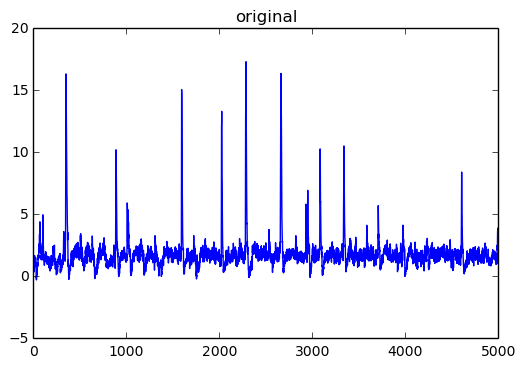

In [62]:
#peak detection testing
transients = np.copy(real_traces)[25][:,None]
viz(transients, title='original')

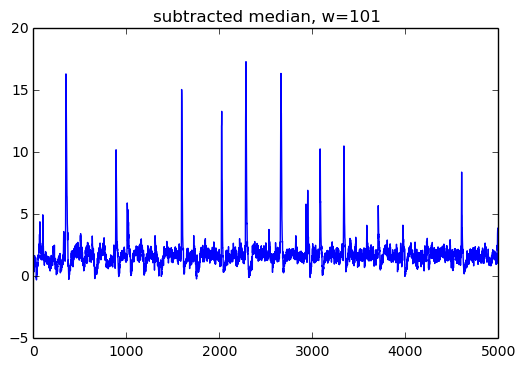

In [63]:
transients_sub_med = subtract_median_window(transients)
viz(transients_sub_med, title='subtracted median, w=101')

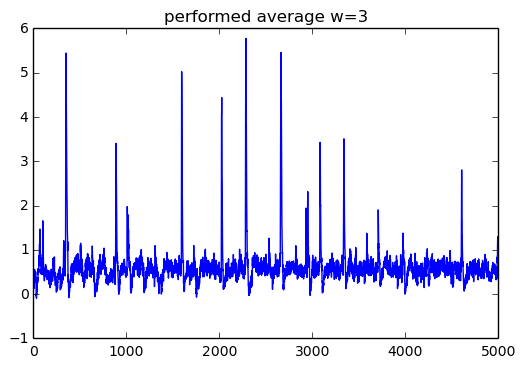

In [64]:
transients_cleaned = sliding_average(transients_sub_med)
viz(transients_cleaned, title='performed average w=3')

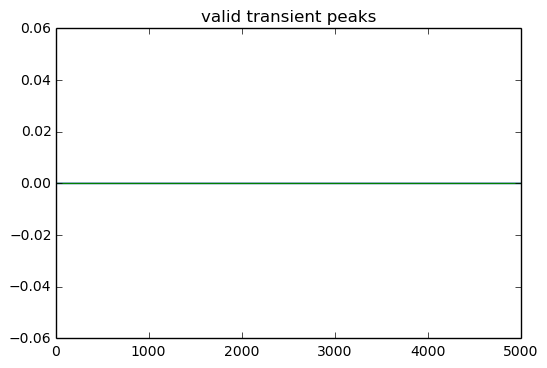

In [65]:
transients_maxima = detect_maxima(transients_cleaned)
viz(transients_maxima, title='valid transient peaks')

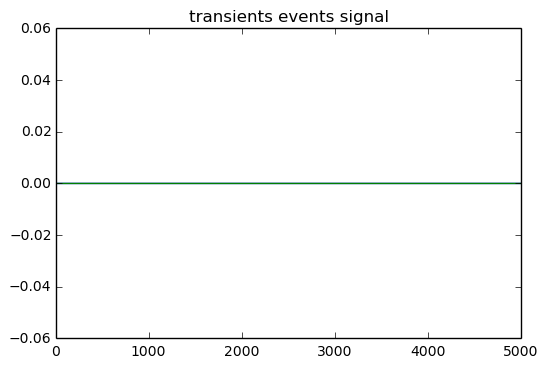

In [58]:
transients_canvas = expand_transients(transients_maxima, transients_cleaned)
viz(transients_canvas, title='transients events signal')

In [ ]:
transient_dots = process_transient_dots(transients_maxima, transients_cleaned)
#TODO this is the transients, but they still need to be filtered by the no firing neighbors rule,
# and need to contain magnitude info (value at peak) #DONE
cell_ids, time_inds, magnitudes = transient_dots
print 'cell_ids', cell_ids.shape
print 'time_inds', time_inds.shape
print 'magnitudes', magnitudes.shape
print 'total values', np.prod(real_traces.shape)
print 'avg time between transients (s)', 0.1/(1.0*magnitudes.shape[0]/np.prod(real_traces.shape))
#print 'avg again', cell_ids[:200], time_inds[:200]
from itertools import groupby
print 'avg time between transients (s)', 0.1*np.mean(
    np.hstack(np.diff(map(lambda x:x[1],list(g)))
              for k,g in 
              groupby(enumerate(time_inds),
                      lambda x: cell_ids[x[0]])
             )
)

In [ ]:
def colorf(i):
    colors = ['r', 'y', 'g', 'c', 'b', 'm', 'k']
    return colors[i % len(colors)]

cell_transients = {k:map(np.array,zip(*[(t,m) for _,t,m in g])) for k,g in groupby(zip(*transient_dots), lambda x:x[0])}
print np.argmax([len(ts) for k,(ts,mags) in cell_transients.iteritems()])
    
#map_transients(cell_ids[:1000], time_inds[:1000], magnitudes[:1000], xy_pos, colorf)
#####for k in cell_transients:
#####    map_transients({6:cell_transients[k]}, xy_pos, 1e6, colorf, title=str(k))

15003

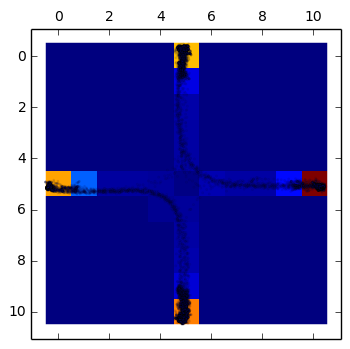

In [37]:
xy_pos = xy_pos.dot(np.array([[1,1],[-1,1]])/np.sqrt(2))
xs, ys = xy_pos[:,0], xy_pos[:,1]
(xs,ys)
ux, nx = min(xs), max(xs)
uy, ny = min(ys), max(ys)
divs = 11
eps = 0.000001
xrs = np.int64(np.trunc(rescale(xs,divs) - eps))
yrs = np.int64(np.trunc(rescale(ys,divs) - eps))
(xs, xrs)
locs = np.zeros((divs,divs), dtype=np.int)
for i in xrange(len(xrs)):
    locs[xrs[i],yrs[i]] += 1
plt.matshow(locs)
plt.hold(True)
plt.scatter(10 - rescale(xy_pos[:,0],divs) + 0.5, 10 - rescale(xy_pos[:,1],divs) + 0.5, alpha=0.1, s=1)
np.sum(locs)

In [ ]:
#%%prun

#given xrs, yrs, alternatively posrs, & divs
#cell_ids, time_inds
locs = np.zeros((divs,divs), dtype=np.int)
for i in xrange(len(xrs)):
    locs[xrs[i],yrs[i]] += 1
#locs is the number of times at a location
p_x = 1.0*(locs + 1) / (np.sum(locs) + divs*divs) #using rule of succession
lp_x = np.log(p_x)
cell_locs = np.zeros((np.max(cell_ids)+1, divs, divs), dtype=np.int)
for cell, t in zip(cell_ids, time_inds):
    cell_locs[cell, xrs[t], yrs[t]] += 1
#cell_locs is a categorization of each transient by location and cell
p_fire_given_loc = 1.0* (cell_locs + 1) / (locs + 2) #using rule of succession
lp_f = np.log(p_fire_given_loc)
def flip_by_pattern(lps, pattern):
    signs = pattern*2-1
    #convert log probs to logodds
    lodds = lps - np.log1p(-np.exp(lps))
    lodds = lodds * signs[:,np.newaxis,np.newaxis]
    return -np.log1p(np.exp(-lodds))
    # -log1p(exp(-(lps - log1p(-exp(lps)))*(pattern*2-1)[:,np.newaxis,np.newaxis]))
def infer_x(lp_f, lp_x, pattern):
    ev = flip_by_pattern(lp_f, pattern)
    return np.sum(ev, axis=0) + lp_x
def x_map(lp_f, lp_x, pattern):
    px = np.exp(infer_x(lp_f, lp_x, pattern))
    px /= np.sum(px)
    return px


def desparse(i1, i2):
    x = np.zeros((np.max(i1)+1, np.max(i2)+1), dtype=np.int)
    for (i,j) in zip(i1,i2):
        x[i,j] += 1
    return x

def number_of_times_at_location(x0,y0):
    count = 0
    for (x, y) in zip(xrs, yrs):
        if (x, y) == (x0, y0):
            count += 1
    return count
def number_of_firings_at_location_by_neuron(cell, x0, y0):
    count = 0
    ts, mags = cell_transients[cell]
    for (x, y) in zip(xrs[ts], yrs[ts]):
        if (x, y) == (x0, y0):
            count += 1
    return count

def prob_neuron_firing_given_location(cell, x0, y0):
    return 1.0* (number_of_firings_at_location_by_neuron(cell, x0, y0)+1) / (number_of_times_at_location(x0, y0)+2)

def prob_location(x0, y0):
    count = 0
    for (x, y) in zip(xrs, yrs):
        if (x, y) == (x0, y0):
            count += 1
    return 1.0*count/len(xrs) 

def prob_neuron_firing(cell):
    ts, mags = cell_transients[cell]
    return 1.0*(len(ts)+1)/(len(xrs)+2)
def prob_pair(cell1, cell2):
    ts1, _ = cell_transients[cell1]
    ts2, _ = cell_transients[cell2]
    both = list(set(ts1) & set(ts2))
    return 1.0*(len(both)+1)/(len(xrs)+2)

def prob_location_given_pattern(x, y, pattern):
    prob = prob_location(x,y)
    for cell, is_firing in enumerate(pattern):
        prob *= prob_neuron_firing_given_location(cell, x, y) / prob_neuron_firing(cell)
    return prob

print prob_location_given_pattern(8,8, [1,1,1,1])
print prob_neuron_firing_given_location(3,8,8)/prob_neuron_firing(3)
print prob_neuron_firing(0) * prob_neuron_firing(1)
print prob_pair(76,99)
signal = desparse(cell_ids, time_inds).T
print signal.shape



#import time
#ax = plt.subplot()
#for t, pattern in enumerate(signal[:20]):
#    actual = np.zeros((divs, divs))
#    actual[xrs[t], yrs[t]] = 1
#    ax.matshow(np.hstack((x_map(lp_f, lp_x, pattern), actual)))
#    plt.title(t)
#    plt.show()
#    print t, 
#    time.sleep(1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim

fig, ax = plt.subplots()

blank = np.hstack((np.zeros((divs,divs)), np.ones((divs,divs))))
mat = ax.matshow(blank, cmap=plt.get_cmap('Greys'))
#mat = ax.matshow(np.zeros((10,10)))

#def animate(i):
#    A = np.zeros((10,10))
#    A[i/10,i%10] = 1
#    mat.set_data(A)
#    print i,
#    return mat

#def animate(i):
#    mat.set_data((x+i)*(x+i)[:,np.newaxis])
#    return mat,

def animate(t):
    pattern = signal[t]
    actual = np.zeros((divs, divs))
    actual[xrs[t], yrs[t]] = 1
    probmap = x_map(lp_f, lp_x, pattern)
    mat.set_data(np.hstack((probmap == np.max(probmap), actual)))
    if t%1000==0: print t,
    return mat,

def init():
    mat.set_data(np.ma.array(blank, mask=True))
    return mat,


ani = anim.FuncAnimation(fig, animate, np.arange(len(signal)), init_func=init, interval=25, blit=True)
plt.show()

In [ ]:

cell_dist = np.zeros((divs,divs,np.max(cell_ids)+1), dtype=np.int)
for i,t in zip(cell_ids, time_inds):
    cell_dist[xrs[t],yrs[t],i]+=1
#plt.plot(cell_dist)
#plt.plot(np.sort(cell_dist)[::-1])
likelihood = 1.0*cell_dist/np.sum(cell_dist, axis=-1)[:,:,np.newaxis]

cell_ids.shape
time_inds.shape

In [ ]:
def denan(x):
    x[np.isnan(x)] = 0
    return x
def max_lik(lik, n_id):
    wnan = lik[:,:,n_id]
    wnan = denan(wnan)
    return np.unravel_index(np.argmax(wnan), wnan.shape)

print max_lik(likelihood, 76)
plt.matshow(denan(likelihood[:,:,76]))

In [ ]:
xy_pos

In [ ]:
import scipy.cluster.vq as cl
cl.kmeans

ts, mags = cell_transients[76]
obs = xy_pos[ts,:]
cl.kmeans(cl.whiten(obs), 2)

xstd, ystd = np.std(obs[:,0]), np.std(obs[:,1])

def jump_method(X, cutoff=20):
    n, p = X.shape
    X = cl.whiten(X)
    Y = p/2.0
    D = np.zeros((n+1,))
    for k in xrange(1,n+1):
        centroids, d = cl.kmeans(X, k)
        D[k] = d**(-Y)
    J = np.diff(D)[:20]
    return np.argmax(J)+1

k = jump_method(obs)
centroids, _ = cl.kmeans(cl.whiten(obs), k)
map_transients({6:cell_transients[76]}, xy_pos, 1e6, colorf, title=str(76))
plt.hold(True)
plt.scatter(centroids[:,0]*xstd, centroids[:,1]*ystd)

In [ ]:
ks = []
for tr in cell_transients:
    ts, mags = cell_transients[tr]
    obs = xy_pos[ts,:]
    k = jump_method(obs)
    ks.append(k)
    print '%d:%d, ' % (tr, k),
    centroids, _ = cl.kmeans(cl.whiten(obs), k)
    xstd, ystd = np.std(obs[:,0]), np.std(obs[:,1])
    map_transients({6:cell_transients[tr]}, xy_pos, 1e6, colorf, title=str(tr))
    plt.hold(True)
    plt.scatter(centroids[:,0]*xstd, centroids[:,1]*ystd)

plt.hold(False)
plt.hist(ks)

In [ ]:



fig, ax = plt.subplots()
ax.imshow(backg)
for ind in range(real_traces.shape[0]):
    map_index(ind, ax, color=colorf(ind))
plt.title('spike places')

In [ ]:
means = np.mean(real_traces, axis=1)
stds = np.std(real_traces, axis=1)
z=3

for setof7 in np.arange(real_traces.shape[0]).reshape(real_traces.shape[0]/7,7):
    a_traces = []
    a_poss = []
    for i in setof7:
        peak_call_filter = real_traces[i,:] > means[i]+z*stds[i]
        a_trace = real_traces[i, peak_call_filter]
        a_pos = xy_pos[peak_call_filter, :]
        
        a_traces.append(a_trace)
        a_poss.append(a_pos)
    map_traces(a_traces, a_poss, colors=map(colorf, range(7)), titl='place coding for cells %s' % str(setof7))
    